# Project: Employee Turnover and Satisfaction Analysis Using Machine Learning Algorithms

**Project goal: Build models for the HR department of the company "Careful Work" to predict employee satisfaction level and whether an employee will leave the company, based on customer data.**

In [1]:
pip install -r requirements.txt

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    MinMaxScaler,
    LabelEncoder
)
from sklearn.linear_model import (
    LogisticRegression,
    Ridge,
    Lasso,
    LinearRegression
)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    r2_score,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error,
    roc_auc_score,
    make_scorer
)



RANDOM_STATE = 44
TEST_SIZE = 0.25

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)

## Task 1: Predicting Employee Satisfaction Level

### Data Loading

**Data description:**
1. **train_job_satisfaction_rate.csv - training set**
   * id — unique employee identifier;
   * dept — department;
   * level — job level;
   * workload — workload level;
   * employment_years — years at the company;
   * last_year_promo — promotion in the last year;
   * last_year_violations — labor contract violations in the last year;
   * supervisor_evaluation — supervisor's evaluation;
   * salary — monthly salary;
   * job_satisfaction_rate — employee satisfaction level, target variable.
    
    
2. **test_features.csv - test set features**
    
3. **test_target_job_satisfaction_rate.csv - test set target**

In [3]:
df_train = pd.read_csv("train_job_satisfaction_rate_fixed.csv", sep=',').set_index('id')
df_train.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


**There are missing values in the data, data types are as expected.**

In [5]:
df_test_feature = pd.read_csv("test_features.csv", sep=',').set_index('id')
df_test_feature.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [6]:
df_test_feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


**There are missing values in the data, data types are as expected.**

In [7]:
df_test_target = pd.read_csv("test_target_job_satisfaction_rate.csv", sep=',').set_index('id')
df_test_target.head()

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


In [8]:
df_test_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


In [9]:
df_test = df_test_feature.join(df_test_target)
df_test.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


**Intermediate data summary:**
   * Training and test data contain missing values
   * Training and test set sizes: 4000 and 2000 entries respectively
   * Target is continuous numeric, regression task
   * Two discrete numeric features (supervisor_evaluation, employment_years), one continuous numeric (salary), two binary categorical (last_year_promo, last_year_violations), one nominal categorical (dept), two ordinal categorical (level, workload)

### Data Preprocessing

In [10]:
df_train.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

In [11]:
for col in df_train.select_dtypes(exclude='number').columns:
    print(col,':',df_train[col].unique())

dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level : ['junior' 'middle' 'senior' nan]
workload : ['medium' 'high' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


**Column names and categorical values in the training data do not require preprocessing.**

In [12]:
df_test.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'],
      dtype='object')

In [13]:
for col in df_test.select_dtypes(exclude='number').columns:
    print(col,':',df_test[col].unique())

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' ' ']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


**Test data contains missing values as both np.nan and spaces. Column names and values are correct. Replace spaces with np.nan and fill missing values using SimpleImputer.**

In [14]:
df_test = df_test.replace(to_replace=' ', value=np.nan)

In [15]:
simple_imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='most_frequent'
) 

In [16]:
imp_num_c = df_train.select_dtypes(include='number').columns
imp_cat_c = df_train.select_dtypes(exclude='number').columns

In [17]:
simple_imputer.fit(df_train.select_dtypes(include='number'))
df_train[imp_num_c] = simple_imputer.transform(df_train[imp_num_c])
df_test[imp_num_c] = simple_imputer.transform(df_test[imp_num_c])


In [18]:
simple_imputer.fit(df_train.select_dtypes(exclude='number'))
df_train[imp_cat_c] = simple_imputer.transform(df_train[imp_cat_c])
df_test[imp_cat_c] = simple_imputer.transform(df_test[imp_cat_c])

In [19]:
df_train.isna().any()

dept                     False
level                    False
workload                 False
employment_years         False
last_year_promo          False
last_year_violations     False
supervisor_evaluation    False
salary                   False
job_satisfaction_rate    False
dtype: bool

In [20]:
df_test.isna().any()

dept                     False
level                    False
workload                 False
employment_years         False
last_year_promo          False
last_year_violations     False
supervisor_evaluation    False
salary                   False
job_satisfaction_rate    False
dtype: bool

**Missing values removed, moving to duplicate handling.**

In [21]:
df_train.duplicated().sum()

248

In [22]:
df_test.duplicated().sum()

83

**Remove duplicates.**

In [23]:
df_train.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [24]:
df_train.shape[0]

3752

In [25]:
df_test.shape[0]

1917

**Proceeding to EDA.**

### Exploratory Data Analysis

**For numeric features, plot histograms and boxplots. For categorical features, plot distributions. For boxplots, group by job level.**

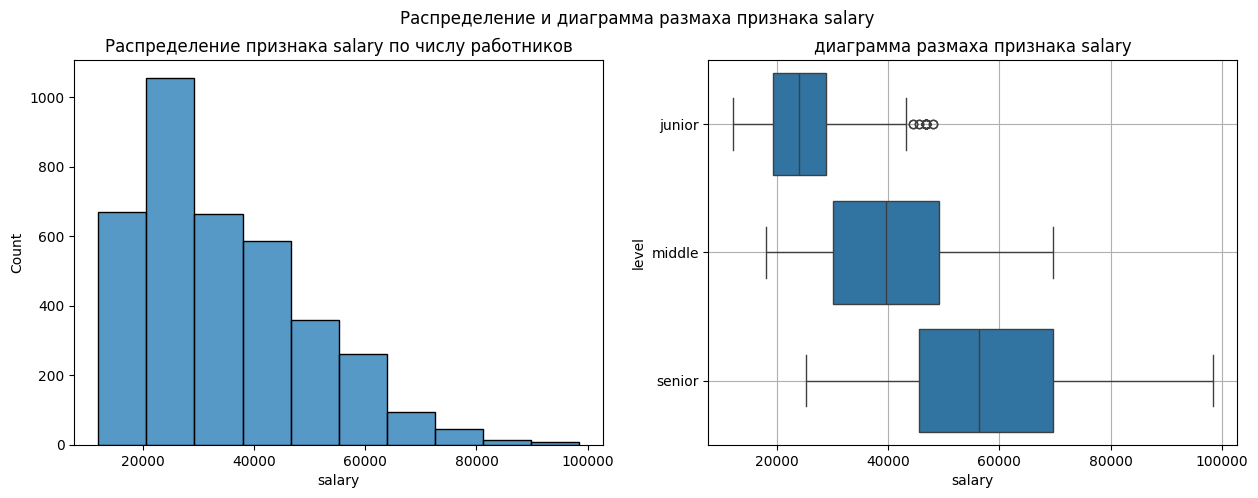

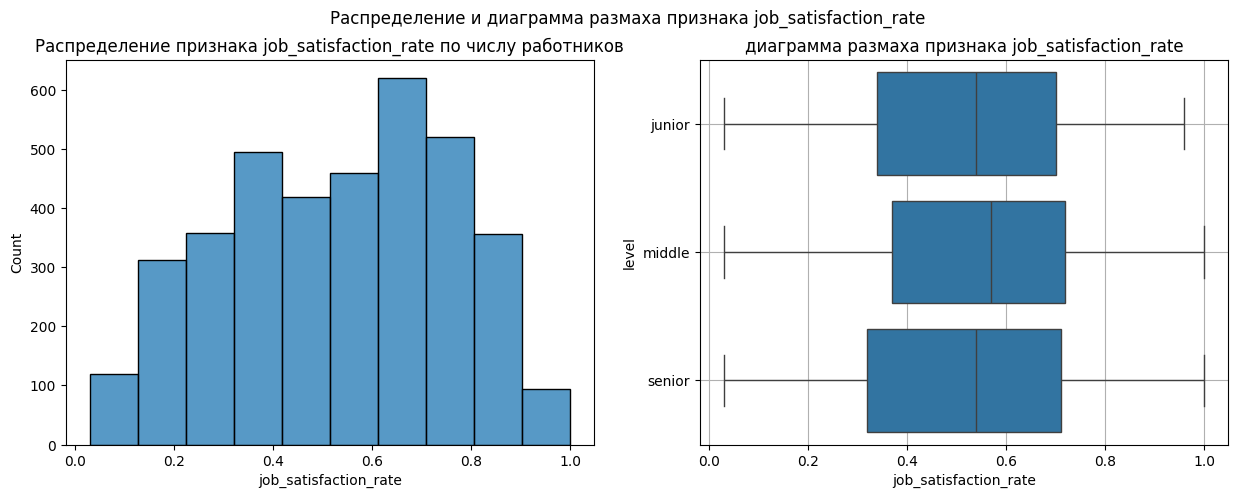

In [26]:
num_cont = ['salary', 'job_satisfaction_rate']
for col in num_cont:
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    fig.suptitle(f'Распределение и диаграмма размаха признака {col}')
    ax[0].set_title(f'Распределение признака {col} по числу работников')
    ax[1].set_title(f'диаграмма размаха признака {col}')
    sns.histplot(data=df_train, x=col, ax=ax[0], bins=10)
    sns.boxplot(data=df_train, x=col, ax=ax[1], y='level')
    plt.grid()
    

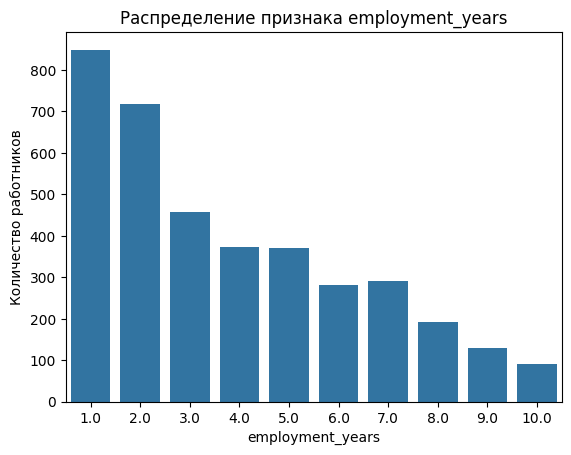

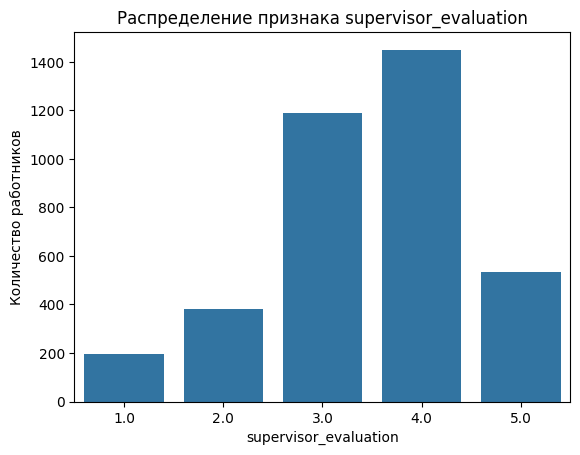

In [27]:
num_disc = ['employment_years', 'supervisor_evaluation']
for col in num_disc:
    plt.title(f'Распределение признака {col}')
    sns.countplot(data=df_train, x=col)
    plt.ylabel('Количество работников')
    plt.show()

In [28]:
df_train.select_dtypes(include='number').describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,3752.000000,3752.000000,3752.000000,3752.000000
mean,3.819296,3.463220,34463.219616,0.532535
std,2.556922,1.026304,15055.252759,0.226424
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.350000
50%,3.000000,4.000000,31200.000000,0.550000
75%,6.000000,4.000000,44400.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


**Observations from the plots above:**
 * Numeric features are on different scales and need scaling
 * No extreme outliers observed
 * Salary increases with job level
 * Satisfaction rate boxplot looks similar across job levels, with median slightly higher for middle specialists

**Now plot distributions for categorical features.**

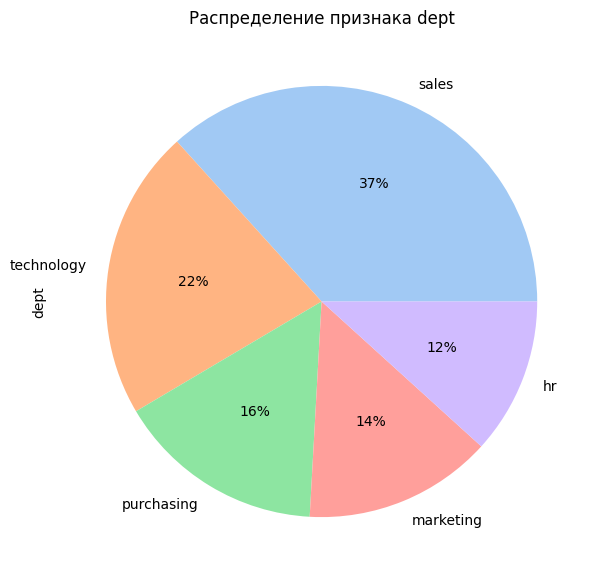

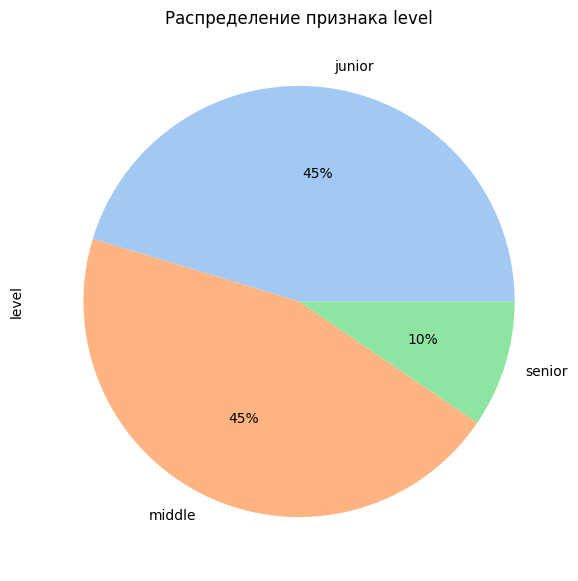

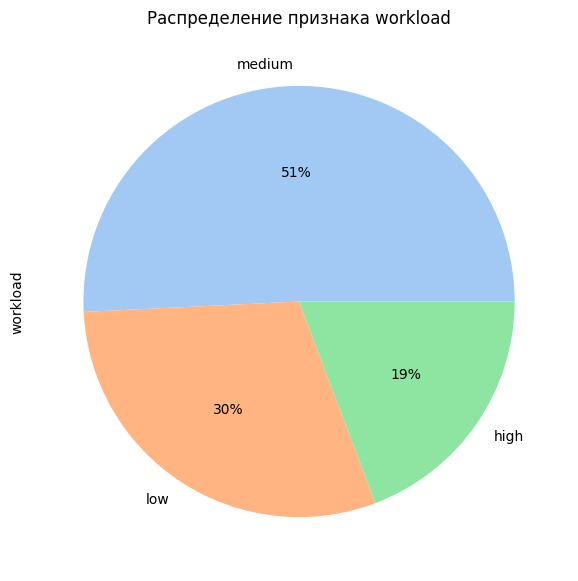

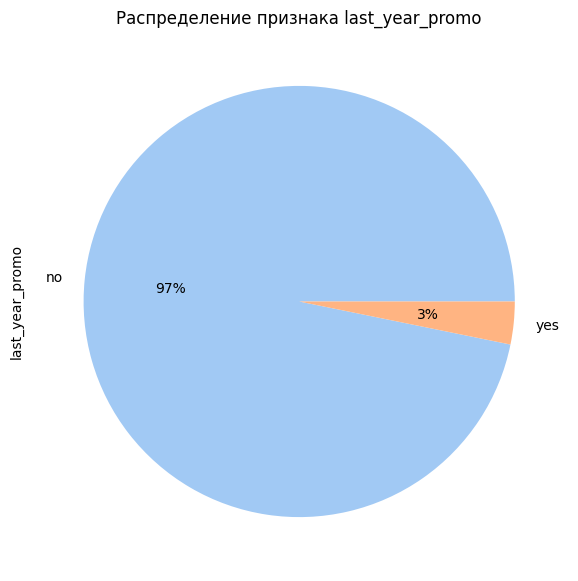

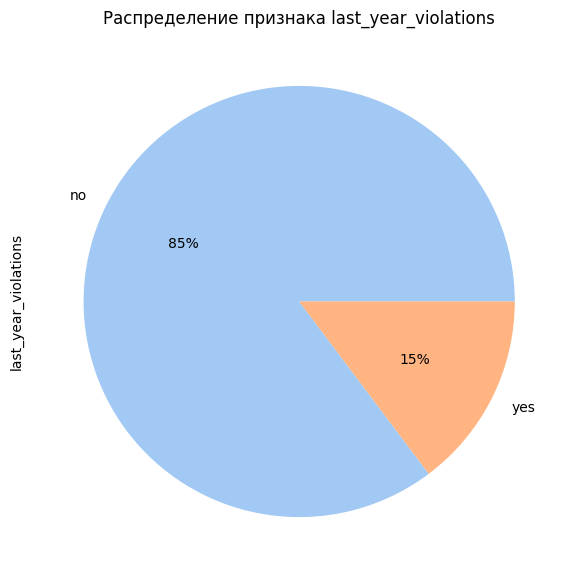

In [29]:
category_names = list(df_train.select_dtypes(include='object').columns)
palette_color = sns.color_palette('pastel') 
for name in category_names:
    plt.figure(figsize=(7,7))
    plt.title(f'Распределение признака {name}')
    df_train.groupby(name)[name].count().sort_values(ascending=False).plot(
    kind='pie',
    autopct='%1.0f%%',
    colors=palette_color
    )


In [30]:
for col in df_train.select_dtypes(exclude='number').columns:
    print(col,':',df_train[col].unique())

dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing']
level : ['junior' 'middle' 'senior']
workload : ['medium' 'high' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


**Categorical feature observations:**
   * Most employees work in sales
   * Equal number of junior/middle specialists, 10% seniors
   * Only 3% got promoted last year
   * 15% violated labor contract
   * last_year_promo and last_year_violations are binary, use OHE; workload and level are ordinal, use OrdinalEncoder; dept is nominal, use OHE.

**Now perform correlation analysis.**

**For quantitative features, plot heatmap of correlation coefficients.**

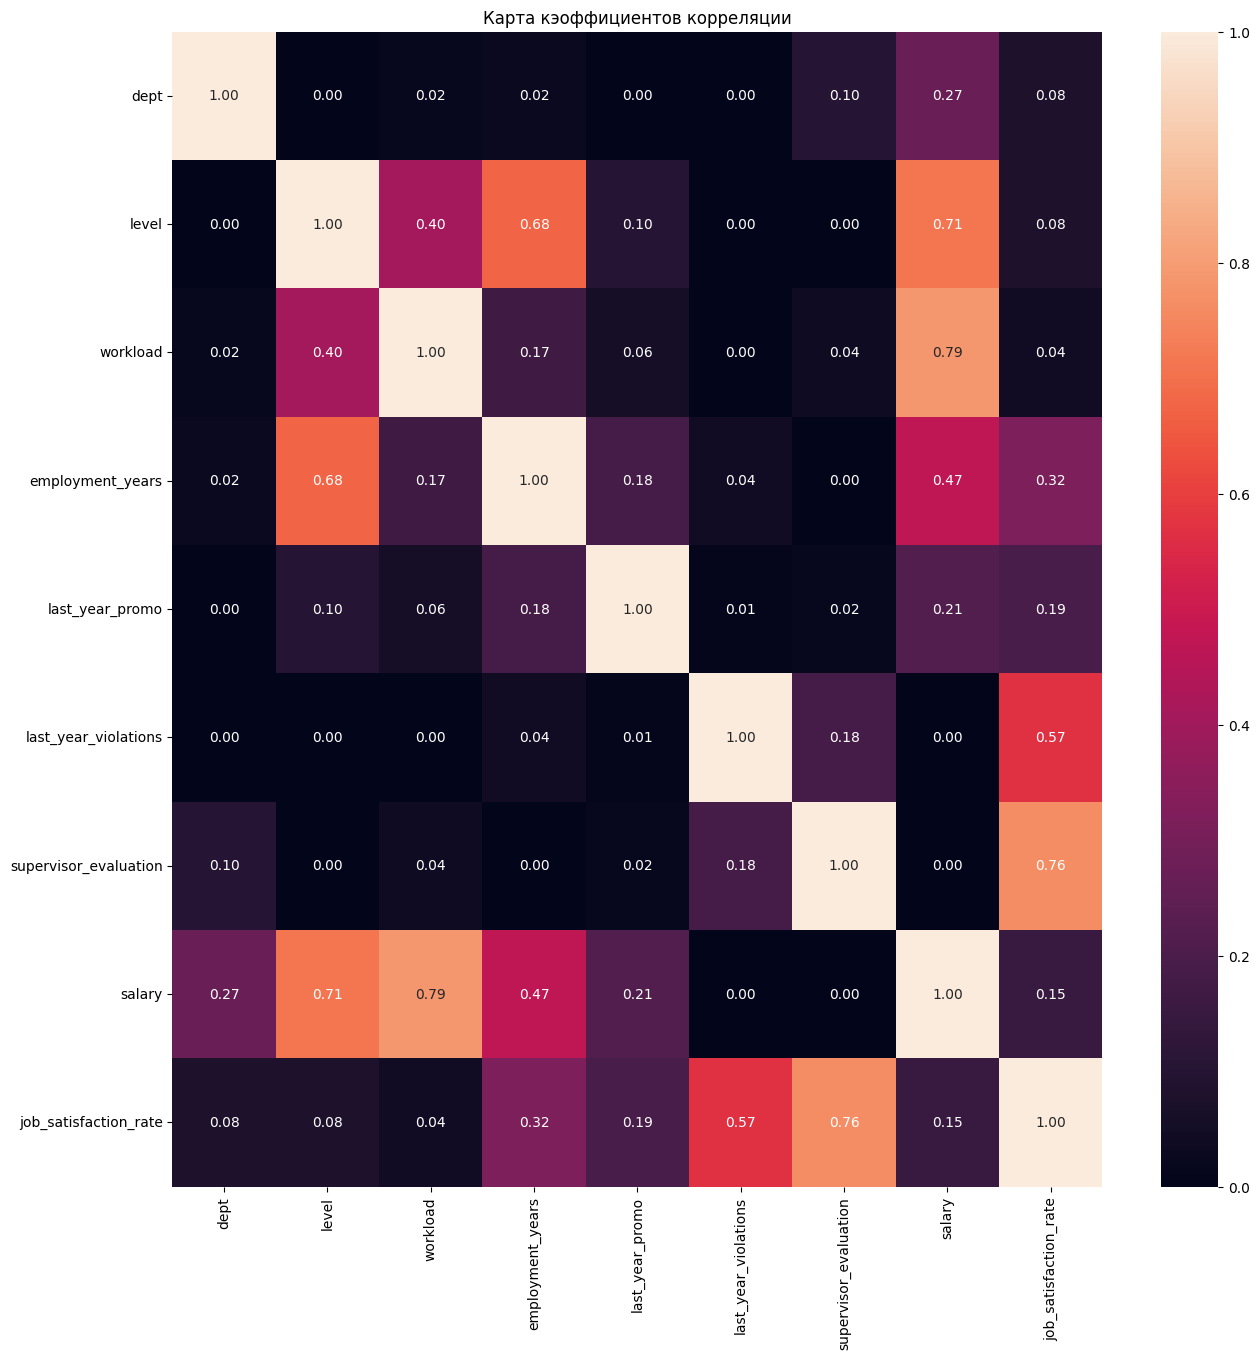

In [31]:
interval_cols = ['salary', 'job_satisfaction_rate']
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Карта кэоффициентов корреляции')
sns.heatmap(df_train.phik_matrix(interval_cols=interval_cols),
            annot=True, 
            fmt='.2f',
            ax=ax) 
print()

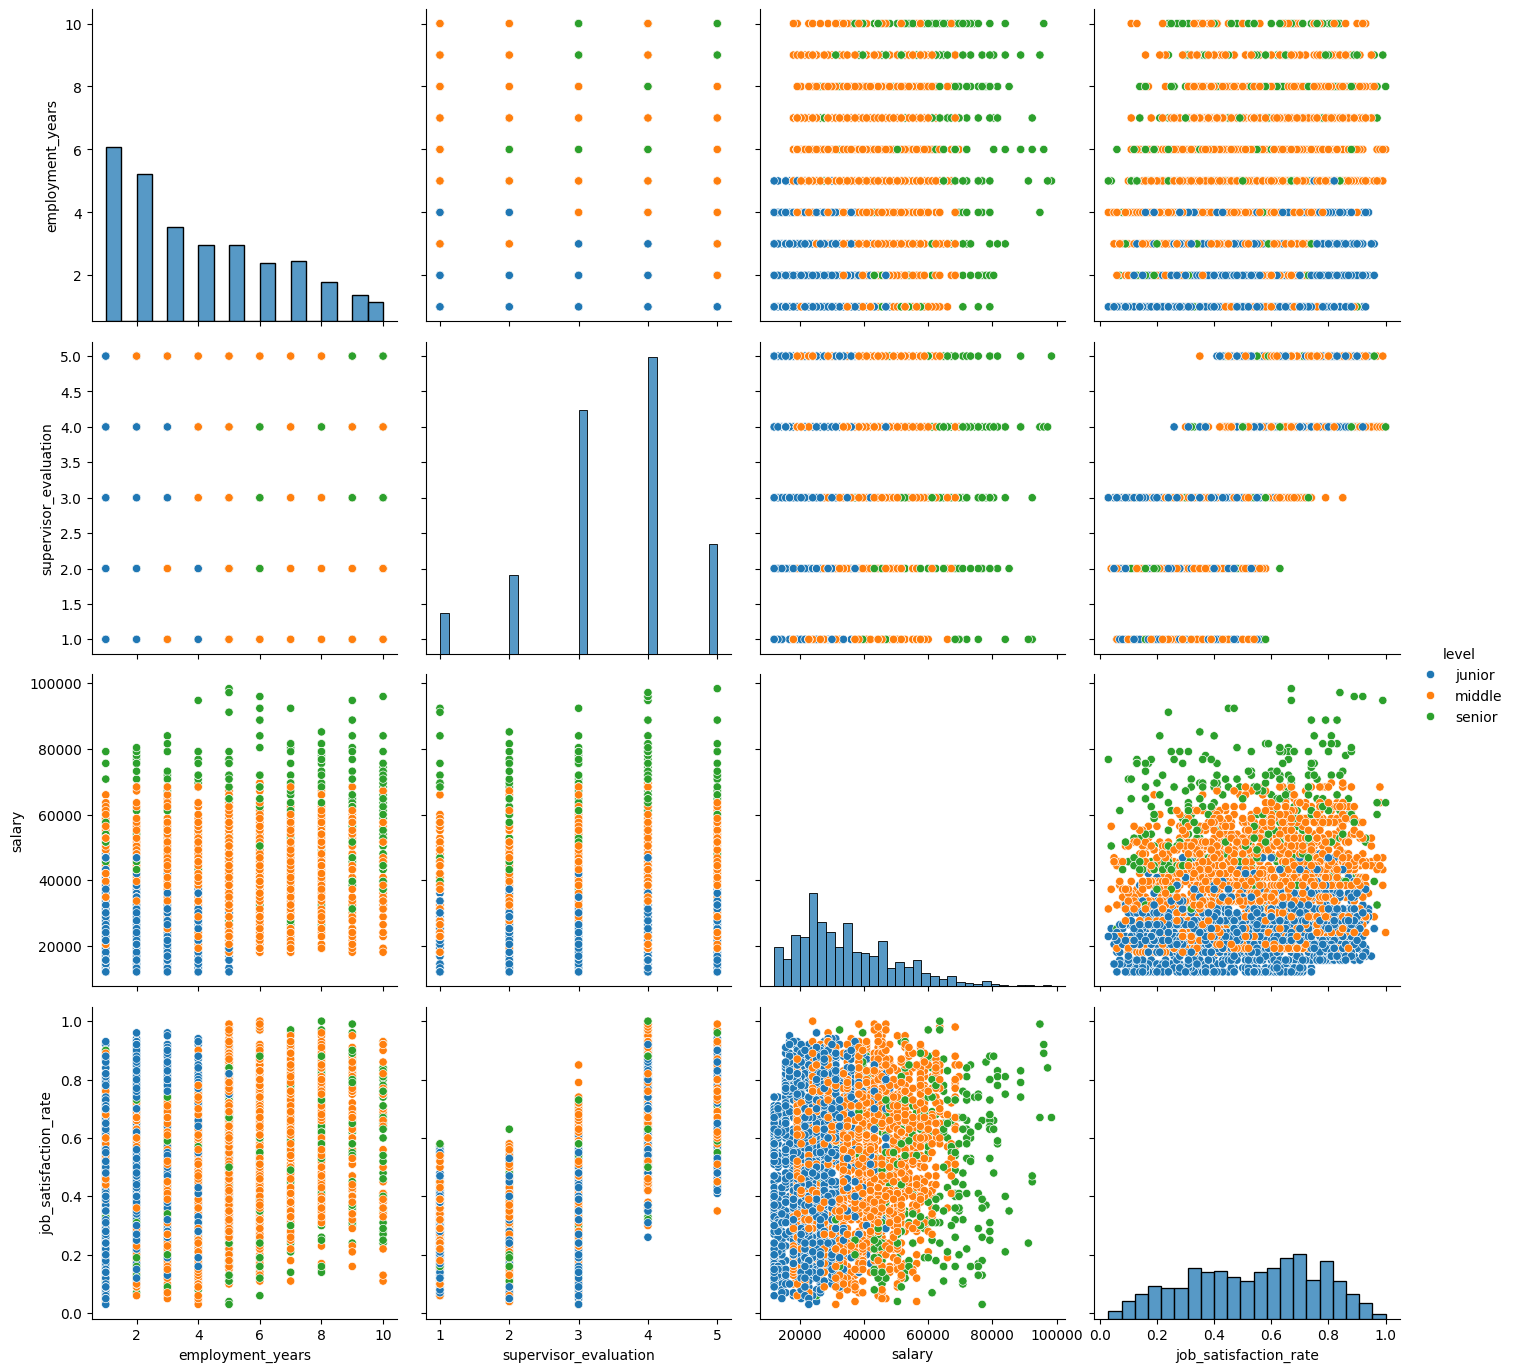

In [32]:
pair = sns.PairGrid(df_train, hue="level", height=3.5)
pair.map_diag(sns.histplot, hue=None)
pair.map_offdiag(sns.scatterplot)
pair.add_legend()

In [33]:
phik_df = df_train.phik_matrix(interval_cols=interval_cols)

**Show correlations above 0.5.**

In [34]:
phik_filtered = phik_df.where((phik_df > 0.5)).stack().index.to_list()
corr_dict = {}
for elem in phik_filtered:
    if (elem[0] != elem[1]) & (elem[::-1] not in corr_dict.keys()):
        corr_dict[elem] = phik_df.loc[elem]
pd.Series(corr_dict).sort_values(ascending=False)

workload               salary                   0.785260
supervisor_evaluation  job_satisfaction_rate    0.762883
level                  salary                   0.714463
                       employment_years         0.675524
last_year_violations   job_satisfaction_rate    0.566976
dtype: float64

**Highly correlated feature pairs: workload-salary, level-salary, level-employment_years.**

**Strong correlation with target job_satisfaction_rate for supervisor_evaluation and last_year_violations.**

**No strong multicollinearity observed, but consider feature selection later.**

### Data Preparation

**Since RandomSearchCV with built-in cross-validation will be used, just separate target from features.**

In [35]:
X_train = df_train.drop('job_satisfaction_rate', axis=1)
y_train = df_train['job_satisfaction_rate']

X_test = df_test.drop('job_satisfaction_rate', axis=1)
y_test = df_test['job_satisfaction_rate']

X_train.shape, X_test.shape

((3752, 8), (1917, 8))

**Categorical features last_year_promo and last_year_violations are binary (OHE), workload and level are ordinal (OrdinalEncoder), dept is nominal (OHE). All numeric features will be scaled using StandardScaler or MinMaxScaler.**

In [36]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

**Start building pipelines for scaling and encoding.**

In [37]:
ohe_pipe = Pipeline(
     [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
    )

ord_pipe = Pipeline(
     [('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', 
                             unknown_value=np.nan,
                             categories=[
                                         ['junior', 'middle', 'sinior']
                                        ,['low', 'medium', 'high']
                                        ])
     ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     ]
    )

**Combine pipelines for feature processing.**

In [38]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='drop',
    verbose_feature_names_out = False
)

**Create final pipeline.**

In [39]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

**Create parameter grid for model selection.**

In [40]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        #'models__max_depth': range(2, 7),
        'models__max_features': range(2, 9),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели Lasso()
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели Ridge()
    {
        'models': [Ridge(random_state=RANDOM_STATE)],
        'models__alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
]

### Model Training

**Define metric for model evaluation. SMAPE will be used.**

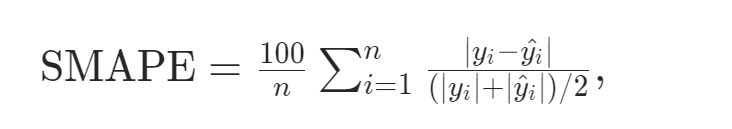

In [41]:
def custom_metric(y_true, y_pred):
    metric = 100 * (2 * abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))).mean()
    
    return metric

SMAPE = make_scorer(custom_metric, greater_is_better=False)

In [42]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring=SMAPE,
    cv=5,
    n_iter=75,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'sinior'],
                                                                                                                           ['low',
                                                                                                                            'me...
                                        {'models': [Lasso(random_state=44)],
                                         'models__alpha': [0.001, 0.01, 0.1, 1,
                                                           2, 5, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [Ridge(random_state=44)],
                                         'models__alpha': [0.001, 0.01, 0.1, 1,
                                                           2, 5, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=44,
                   scoring=make_scorer(custom_metric, greater_is_better=False, response_method='predict'))

In [43]:
pd.set_option('display.max_colwidth', 200)
result = pd.DataFrame(randomized_search.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10)

,rank_test_score,param_models,mean_test_score,params
17,1,DecisionTreeRegressor(random_state=44),-15.806862,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models': DecisionTreeRegressor(random_state=44)}"
28,2,DecisionTreeRegressor(random_state=44),-15.823817,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 4, 'models__max_features': 8, 'models': DecisionTreeRegressor(random_state=44)}"
14,3,DecisionTreeRegressor(random_state=44),-15.988900,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 6, 'models__max_features': 8, 'models': DecisionTreeRegressor(random_state=44)}"
20,4,DecisionTreeRegressor(random_state=44),-16.120495,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 2, 'models__max_features': 8, 'models': DecisionTreeRegressor(random_state=44)}"
18,5,DecisionTreeRegressor(random_state=44),-16.251868,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 7, 'models__max_features': 6, 'models': DecisionTreeRegressor(random_state=44)}"
58,6,DecisionTreeRegressor(random_state=44),-16.399436,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 8, 'models__max_features': 8, 'models': DecisionTreeRegressor(random_state=44)}"
63,7,DecisionTreeRegressor(random_state=44),-16.529046,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 3, 'models__max_features': 5, 'models': DecisionTreeRegressor(random_state=44)}"
35,8,DecisionTreeRegressor(random_state=44),-16.821465,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 1, 'models__max_features': 6, 'models': DecisionTreeRegressor(random_state=44)}"
1,9,DecisionTreeRegressor(random_state=44),-16.845781,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 10, 'models__max_features': 8, 'models': DecisionTreeRegressor(random_state=44)}"
36,10,DecisionTreeRegressor(random_state=44),-16.862360,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 12, 'models__max_features': 8, 'models': DecisionTreeRegressor(random_state=44)}"


**All top models are DecisionTreeRegressor, likely due to many categorical features or weak linear dependence of target on numeric features.**

In [44]:
print ('Метрика лучшей модели на кросс-валлидации:', randomized_search.best_score_)

Метрика лучшей модели на кросс-валлидации: -15.806862047629593


In [45]:
y_pred = randomized_search.predict(X_test)
print ('Метрика лучшей модели на тестовой выборке:', custom_metric(y_test, y_pred))

Метрика лучшей модели на тестовой выборке: 14.599500626645264


In [46]:
randomized_search.best_params_

{'preprocessor__num': StandardScaler(),
 'models__min_samples_leaf': 4,
 'models__max_features': 8,
 'models': DecisionTreeRegressor(random_state=44)}

**SMAPE on test set is 14.1 (< 15), keep this model: DecisionTreeRegressor(samples_leaf: 6, max_features: 8) with StandardScaler for numeric features.**

**Check residuals distribution.**

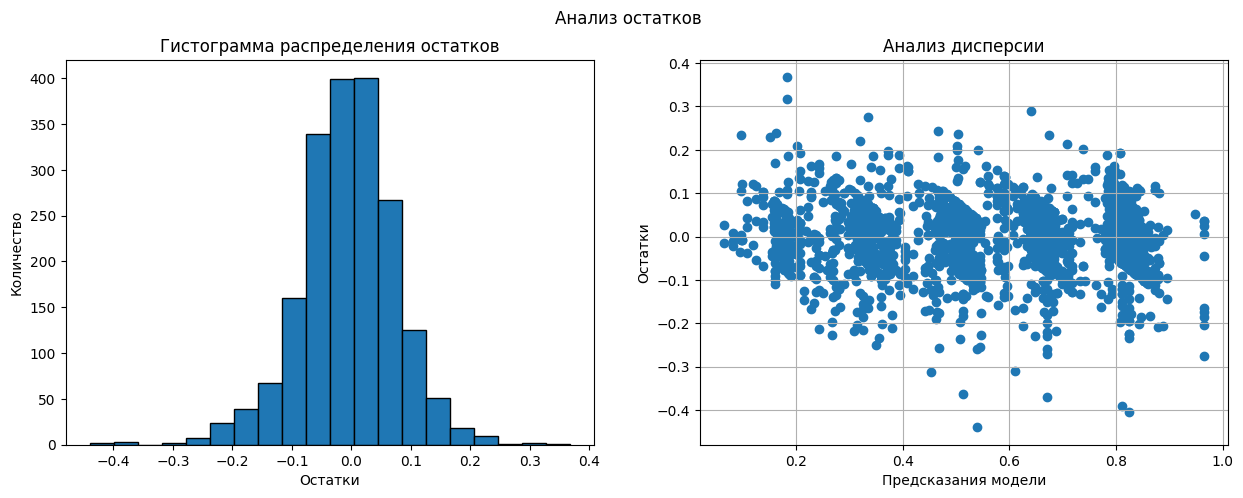

In [47]:
residuals = y_test - y_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Анализ остатков')
axes[0].hist(residuals, bins=20, edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Количество')
axes[1].scatter(x=y_pred, y=residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')

plt.grid()
plt.show()

**Residuals are normally distributed and variance is fairly uniform as predictions increase.**

### Conclusions and Model Interpretation

**Initialize and train the model with best parameters, prepare data.**

In [48]:
model = DecisionTreeRegressor(max_features=8,
                              min_samples_leaf=4,
                              random_state=RANDOM_STATE)

In [49]:
X_train_processed = data_preprocessor.fit_transform(X_train)
X_test_processed = data_preprocessor.transform(X_test)

In [50]:
model.fit(X_train_processed, y_train)

DecisionTreeRegressor(max_features=8, min_samples_leaf=4, random_state=44)

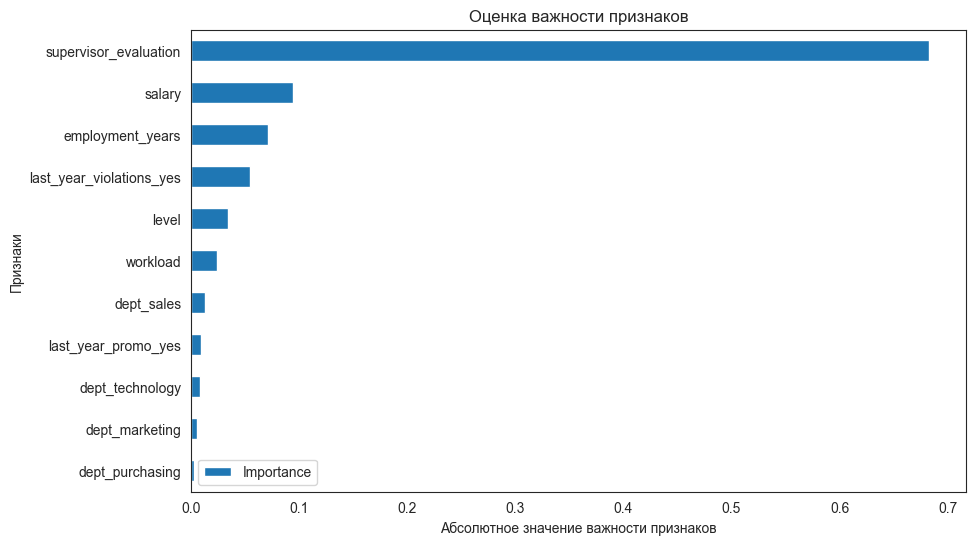

In [51]:
coefficients = model.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': data_preprocessor.get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.xlabel('Абсолютное значение важности признаков')
plt.ylabel('Признаки')
plt.title('Оценка важности признаков');

**By absolute value of coefficients, supervisor_evaluation is most important. Now check SHAP values.**

In [52]:
X_test_df = pd.DataFrame(X_test_processed, columns=data_preprocessor.get_feature_names_out())

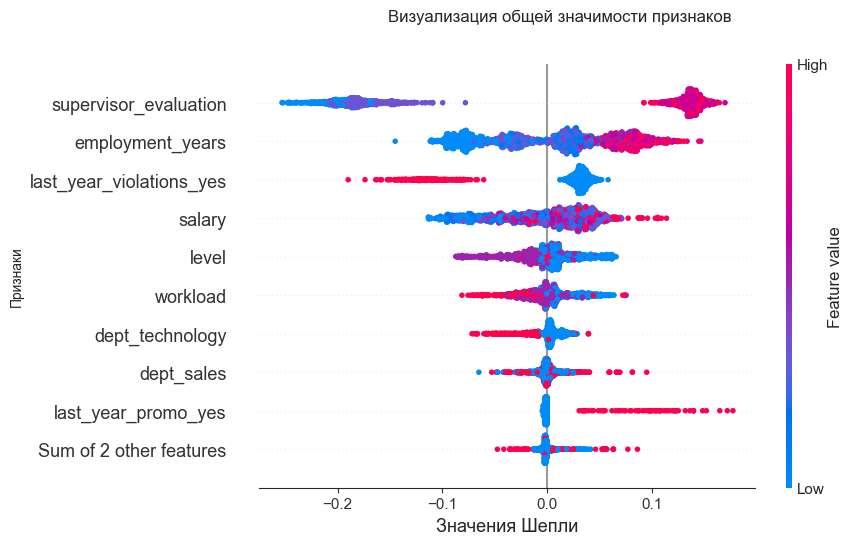

In [53]:
explainer = shap.TreeExplainer(model, X_test_df)
shap_values = explainer(X_test_df)

shap.plots.beeswarm(shap_values, show=False)
fig, ax = plt.gcf(), plt.gca()
fig.suptitle('Визуализация общей значимости признаков')
ax.set_xlabel("Значения Шепли")
ax.set_ylabel("Признаки");

**SHAP summary:**
   * Supervisor evaluation is directly proportional to satisfaction.
   * Labor contract violations decrease satisfaction.
   * Longer employment increases satisfaction.

**Check the object with the largest residual and analyze the model's prediction.**

In [54]:
abs(residuals).sort_values(ascending=False).head()

id
525936    0.440000
270847    0.405000
570729    0.390909
708558    0.370000
342159    0.367500
Name: job_satisfaction_rate, dtype: float64

**Largest error for object with id '525936'.**

<Axes: >

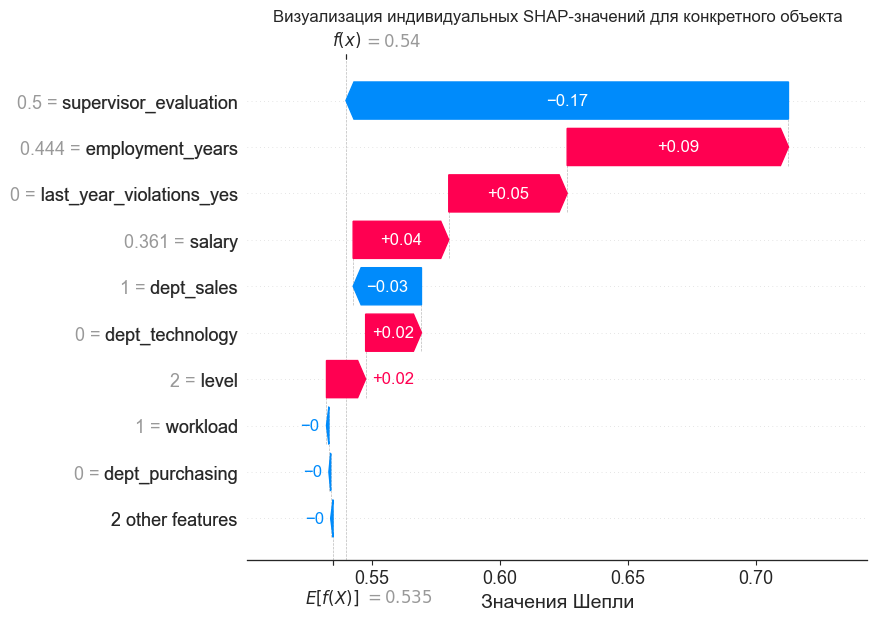

In [55]:
fig, ax = plt.gcf(), plt.gca()
ax.set_title('Визуализация индивидуальных SHAP-значений для конкретного объекта')
ax.set_xlabel("Значения Шепли", fontsize=14)
shap.plots.waterfall(shap_values[X_test.index.get_loc(525936)], show=False)

**SHAP values for this object show supervisor_evaluation contributed most to the error: the employee was rated low but remained satisfied.**

**Task 1 summary:**
   * Unsatisfied employees are rated low by supervisors, have labor violations, and are recently hired
   * Best model (by SMAPE): DecisionTreeRegressor
   * For further improvement, recommend adding categories for supervisor dissatisfaction reasons

## Task 2: Predicting Employee Turnover

### Data Loading

**"quit" is the new binary target variable.**

In [56]:
df_train_quit = pd.read_csv("train_quit.csv", sep=',').set_index('id')
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [57]:
df_train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


**No missing values.**

**Test data differs from previous task only by target, so reuse and change target.**

In [58]:
df_test_quit = df_test
df_test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2.0,no,no,5.0,28800.0,0.79
686555,hr,junior,medium,1.0,no,no,4.0,30000.0,0.72
467458,sales,middle,low,5.0,no,no,4.0,19200.0,0.64
418655,sales,middle,low,6.0,no,no,4.0,19200.0,0.60
789145,hr,middle,medium,5.0,no,no,5.0,40800.0,0.75


In [59]:
df_test_target_quit = pd.read_csv("test_target_quit.csv", sep=',').set_index('id')
df_test_target_quit.head()

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


In [60]:
df_test_quit = df_test_quit.join(df_test_target_quit)
df_test_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2.0,no,no,5.0,28800.0,0.79,no
686555,hr,junior,medium,1.0,no,no,4.0,30000.0,0.72,no
467458,sales,middle,low,5.0,no,no,4.0,19200.0,0.64,no
418655,sales,middle,low,6.0,no,no,4.0,19200.0,0.60,no
789145,hr,middle,medium,5.0,no,no,5.0,40800.0,0.75,no


In [61]:
df_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 485046 to 771859
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   1917 non-null   object 
 1   level                  1917 non-null   object 
 2   workload               1917 non-null   object 
 3   employment_years       1917 non-null   float64
 4   last_year_promo        1917 non-null   object 
 5   last_year_violations   1917 non-null   object 
 6   supervisor_evaluation  1917 non-null   float64
 7   salary                 1917 non-null   float64
 8   job_satisfaction_rate  1917 non-null   float64
 9   quit                   1917 non-null   object 
dtypes: float64(4), object(6)
memory usage: 229.3+ KB


**Intermediate data summary:**
   * Target is binary, classification task
   * Two discrete numeric features (supervisor_evaluation, employment_years), one continuous numeric (salary), two binary categorical (last_year_promo, last_year_violations), one nominal categorical (dept), two ordinal categorical (level, workload)

### Data Preprocessing

In [62]:
df_train_quit.columns

Index(['dept', 'level', 'workload', 'employment_years', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'salary', 'quit'],
      dtype='object')

In [63]:
for col in df_train_quit.select_dtypes(exclude='number').columns:
    print(col,':',df_train_quit[col].unique())

dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level : ['middle' 'junior' 'sinior']
workload : ['high' 'medium' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']
quit : ['no' 'yes']


**No typos in categorical features or column names.**

In [64]:
df_train_quit.isna().any()

dept                     False
level                    False
workload                 False
employment_years         False
last_year_promo          False
last_year_violations     False
supervisor_evaluation    False
salary                   False
quit                     False
dtype: bool

In [65]:
df_test_quit.isna().any()

dept                     False
level                    False
workload                 False
employment_years         False
last_year_promo          False
last_year_violations     False
supervisor_evaluation    False
salary                   False
job_satisfaction_rate    False
quit                     False
dtype: bool

In [66]:
df_train_quit.duplicated().sum()

1413

In [67]:
df_test_quit.duplicated().sum()

0

**Remove duplicates.**

In [68]:
df_train_quit.drop_duplicates(inplace=True)
df_test_quit.drop_duplicates(inplace=True)

In [69]:
df_train_quit.shape[0]

2587

In [70]:
df_test_quit.shape[0]

1917

### Exploratory Data Analysis

**For numeric features, plot histograms and boxplots. For categorical features, plot distributions. For boxplots, group by quit.**

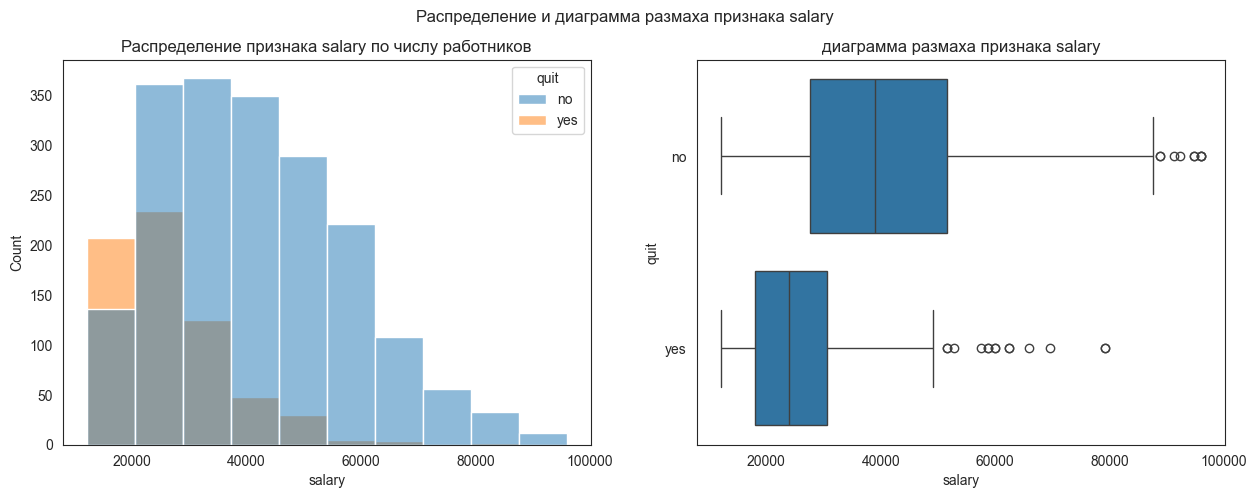

In [71]:
num_cont_quit = ['salary']
for col in num_cont_quit:
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,5))
    fig.suptitle(f'Распределение и диаграмма размаха признака {col}')
    ax[0].set_title(f'Распределение признака {col} по числу работников')
    ax[1].set_title(f'диаграмма размаха признака {col}')
    sns.histplot(data=df_train_quit, x=col, ax=ax[0], bins=10, hue='quit')
    sns.boxplot(data=df_train_quit, x=col, ax=ax[1], y='quit')
    plt.show()
    plt.grid()

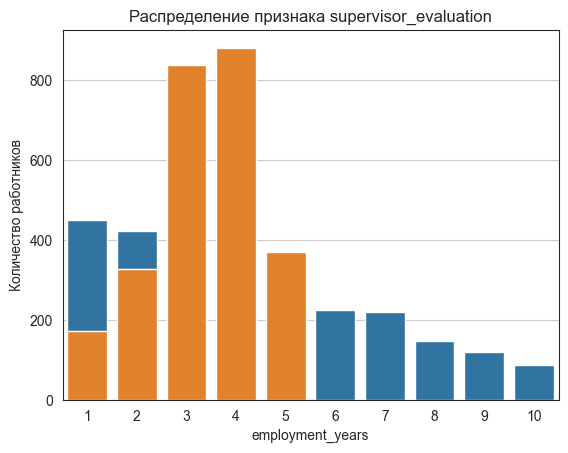

In [72]:
num_disc = ['employment_years', 'supervisor_evaluation']
for col in num_disc:
    plt.title(f'Распределение признака {col}')
    sns.countplot(data=df_train_quit, x=col)
    plt.ylabel('Количество работников')
plt.show()


**Observations:**
   * Employees who left had lower median salary
   * Employees who left were rated lower by supervisors
   * Employees who left worked fewer years, most left after 1-2 years

In [73]:
df_train_quit.query("quit == 'no'")

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
910140,marketing,junior,medium,2,no,no,5,25200,no
417070,technology,middle,medium,8,no,no,2,44400,no
...,...,...,...,...,...,...,...,...,...
557012,technology,middle,medium,4,yes,no,5,46800,no
380294,technology,middle,high,8,no,no,4,63600,no
186752,purchasing,middle,medium,9,no,no,2,32400,no


**Now analyze categorical features, segmented by quit.**

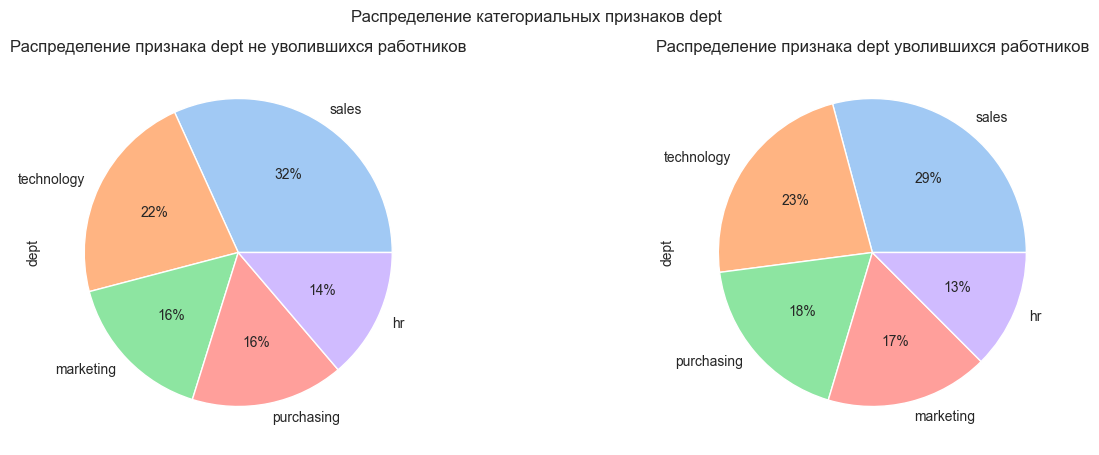

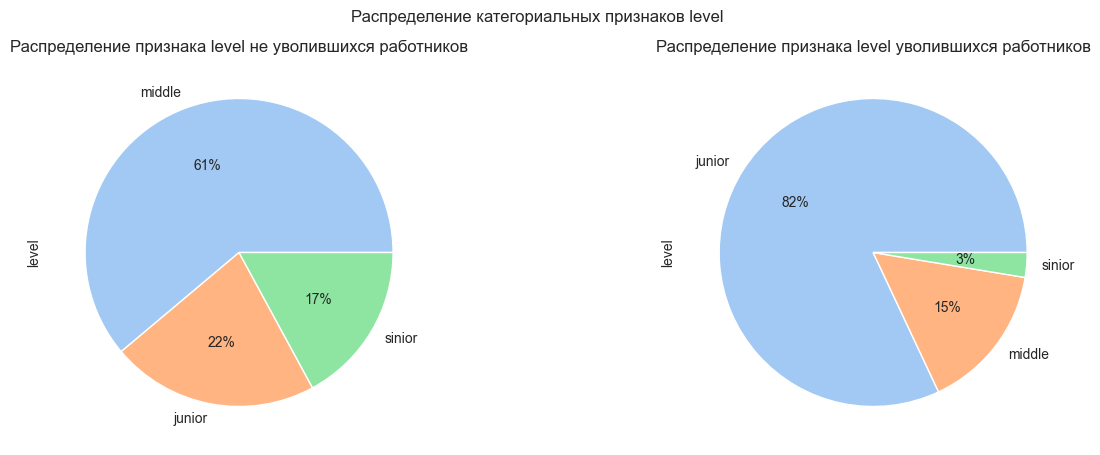

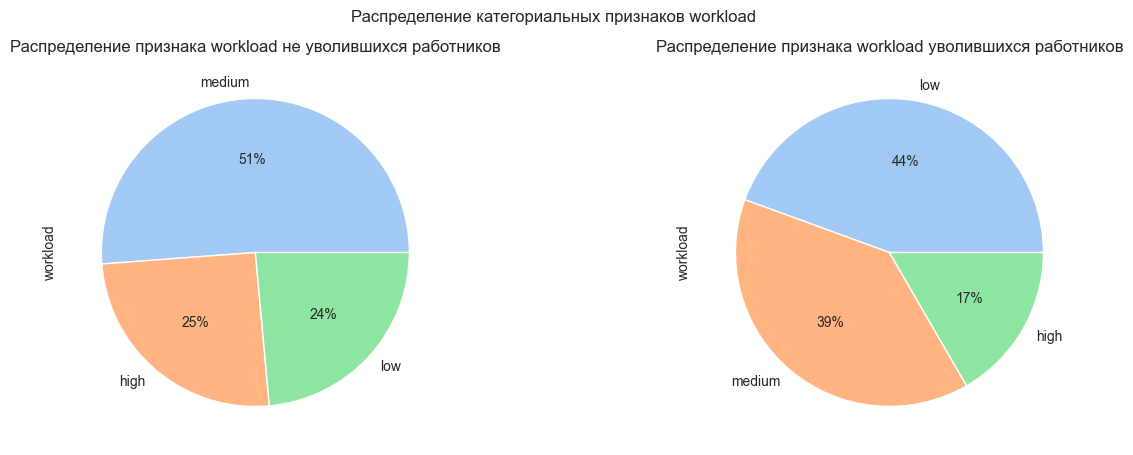

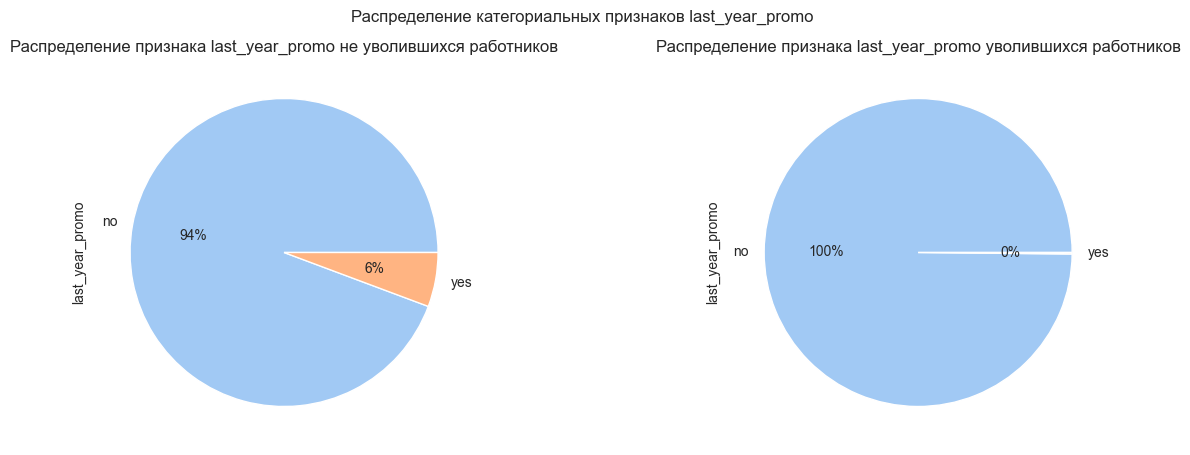

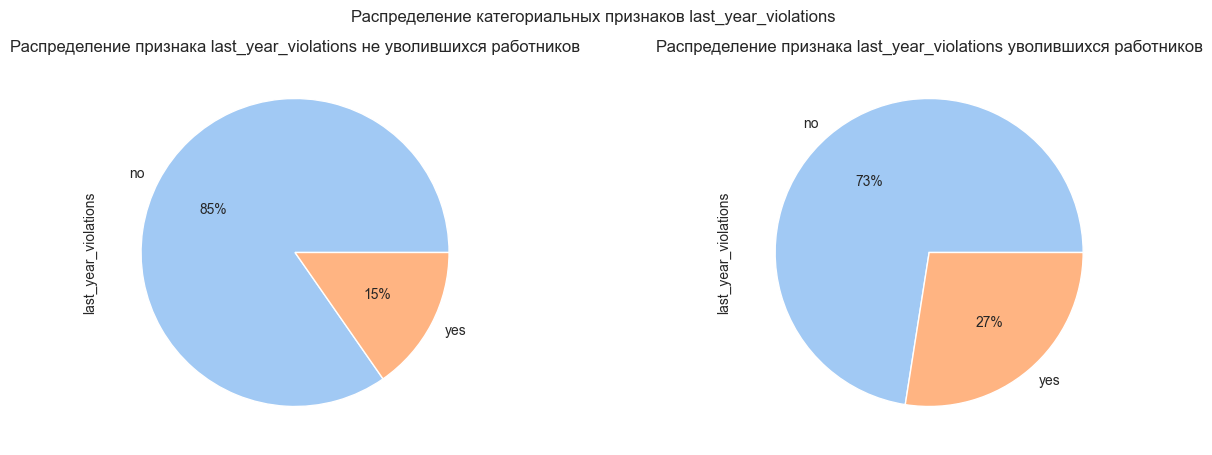

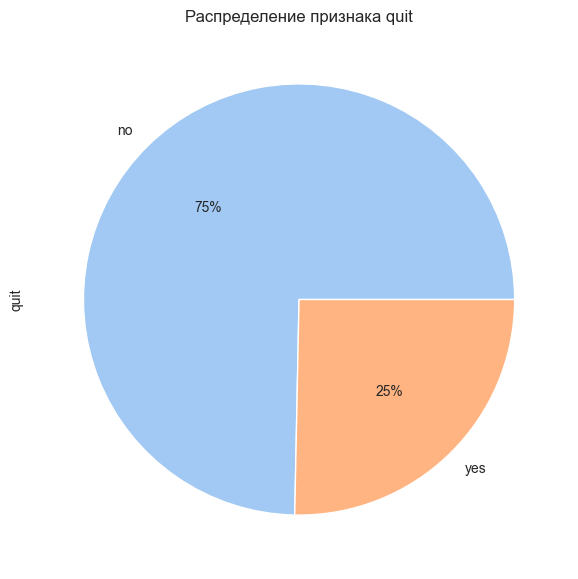

In [74]:
category_names = list(df_train_quit.select_dtypes(include='object').columns)
palette_color = sns.color_palette('pastel') 
for name in category_names:
    if name != 'quit':
        fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,5))
        fig.suptitle(f'Распределение категориальных признаков {name}')
        ax[0].set_title(f'Распределение признака {name} не уволившихся работников')
        ax[1].set_title(f'Распределение признака {name} уволившихся работников')
        (
            df_train_quit.query("quit == 'no'").
            groupby(name)[name].
            count().sort_values(ascending=False).plot(
            kind='pie',
            autopct='%1.0f%%',
            colors=palette_color,
            ax=ax[0]
            )
        )
        (
            df_train_quit.query("quit == 'yes'").
            groupby(name)[name].
            count().sort_values(ascending=False).plot(
            kind='pie',
            autopct='%1.0f%%',
            colors=palette_color,
            ax=ax[1]
            )
        )
    else:
        plt.figure(figsize=(7,7))
        plt.title(f'Распределение признака {name}')
        df_train_quit.groupby(name)[name].count().sort_values(ascending=False).plot(
        kind='pie',
        autopct='%1.0f%%',
        colors=palette_color
        )
        plt.show()

**From the plots:**
   * Department distribution does not differ much by quit, sales is the largest
   * Only 3% of those who left are seniors, 81% are juniors
   * 44% of those who left had low workload
   * None of the who left received a bonus
   * 27% of those who left violated the labor contract, compared to 15% who stayed
   * Target quit is imbalanced: 75/25

**Portrait of a likely leaver:**
   * Most likely works in sales (largest department)
   * Junior specialist
   * Low workload
   * Possibly violated labor contract
   * Supervisor rating 1-3

**Analysts claim satisfaction level affects turnover. Let's check: plot and compare job_satisfaction_rate distributions for leavers and stayers.**

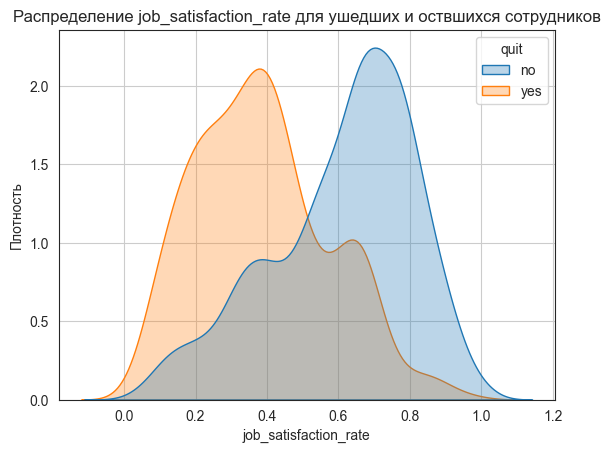

In [75]:
plt.title(f'Распределение job_satisfaction_rate для ушедших и оствшихся сотрудников')
plt.ylabel('Плотность')
plt.grid()
sns.kdeplot(data=df_test_quit, x='job_satisfaction_rate', hue='quit', alpha=0.3, fill=True, common_norm=False)
plt.show()

**Distribution shows leavers peak at satisfaction ~0.4, stayers at ~0.7, indicating an effect.**

### Adding a New Feature

**Add predicted job_satisfaction_rate from Task 1 as a feature for Task 2. Encode target using LabelEncoder.**

In [76]:
original_classes = ['no', 'yes']

lab_encoder = LabelEncoder()
lab_encoder.classes = np.array(original_classes)

df_train_quit['quit'] = lab_encoder.fit_transform(df_train_quit['quit'])
df_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0
814010,sales,junior,medium,2,no,no,4,27600,0
155091,purchasing,middle,medium,5,no,no,1,37200,0
257132,sales,junior,medium,2,no,yes,3,24000,1
910140,marketing,junior,medium,2,no,no,5,25200,0


In [77]:
X_train_quit = df_train_quit.drop('quit', axis=1)
y_train_quit = df_train_quit['quit']

X_test_quit = df_test_quit.drop('quit', axis=1)
y_test_quit = lab_encoder.transform(df_test_quit['quit'])

In [78]:
jsr_pred_quit = randomized_search.predict(X_train_quit)
X_train_quit['job_satisfaction_rate'] = jsr_pred_quit
X_train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.626667
814010,sales,junior,medium,2,no,no,4,27600,0.840769
155091,purchasing,middle,medium,5,no,no,1,37200,0.340000
257132,sales,junior,medium,2,no,yes,3,24000,0.330000
910140,marketing,junior,medium,2,no,no,5,25200,0.791667


In [79]:
X_train_quit.shape, X_test_quit.shape

((2587, 9), (1917, 9))

### Data Preparation

**Reuse previous pipeline, adding job_satisfaction_rate as a numeric feature.**

In [80]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns_quit = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

**Pipeline for scaling and encoding:**

In [81]:
ohe_pipe = Pipeline(
     [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
    )

ord_pipe = Pipeline(
     [('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', 
                             unknown_value=np.nan,
                             categories=[
                                         ['junior', 'middle', 'sinior']
                                        ,['low', 'medium', 'high']
                                        ])
     ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
     ]
    )

**Combine pipelines.**

In [82]:
data_preprocessor_quit = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns_quit)
    ], 
    remainder='drop',
    verbose_feature_names_out = False
)

In [83]:
pipe_final_quit = Pipeline([
    ('preprocessor', data_preprocessor_quit),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

**Create parameter grid for model selection: DecisionTreeClassifier, LogisticRegression, SVC, KNN.**

In [84]:
param_grid_quit = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_leaf': range(1, 15),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            solver='liblinear', 
            penalty='l1',
            random_state=RANDOM_STATE, 
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(
            random_state=RANDOM_STATE,
            probability=True
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 2, 5, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    }
    
]

### Model Training

**Use ROC-AUC as evaluation metric.**

In [85]:
randomized_search_quit = RandomizedSearchCV(
    pipe_final_quit,
    param_grid_quit,
    scoring='roc_auc',
    cv=5,
    n_iter=75,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_quit.fit(X_train_quit, y_train_quit)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['junior',
                                                                                                                            'middle',
                                                                                                                            'sinior'],
                                                                                                                           ['low',
                                                                                                                            'me...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=44)],
                                         'models__C': [0.001, 0.01, 0.1, 1, 2,
                                                       5, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=44, scoring='roc_auc')

In [86]:
pd.set_option('display.max_colwidth', 200)
result = pd.DataFrame(randomized_search_quit.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(10)

,rank_test_score,param_models,mean_test_score,params
26,1,"LogisticRegression(penalty='l1', random_state=44, solver='liblinear')",0.903015,"{'preprocessor__num': StandardScaler(), 'models__penalty': 'l1', 'models__C': 10, 'models': LogisticRegression(penalty='l1', random_state=44, solver='liblinear')}"
21,2,"LogisticRegression(penalty='l1', random_state=44, solver='liblinear')",0.902583,"{'preprocessor__num': MinMaxScaler(), 'models__penalty': 'l2', 'models__C': 5, 'models': LogisticRegression(penalty='l1', random_state=44, solver='liblinear')}"
64,3,DecisionTreeClassifier(random_state=44),0.902319,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 1, 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=44)}"
2,4,DecisionTreeClassifier(random_state=44),0.900753,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 9, 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=44)}"
61,5,DecisionTreeClassifier(random_state=44),0.900550,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 12, 'models__max_features': 5, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=44)}"
27,6,DecisionTreeClassifier(random_state=44),0.900381,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 10, 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=44)}"
70,7,DecisionTreeClassifier(random_state=44),0.900316,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 9, 'models__max_features': 3, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=44)}"
54,8,DecisionTreeClassifier(random_state=44),0.900045,"{'preprocessor__num': MinMaxScaler(), 'models__min_samples_leaf': 5, 'models__max_features': 4, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=44)}"
6,9,DecisionTreeClassifier(random_state=44),0.899694,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 12, 'models__max_features': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=44)}"
36,10,DecisionTreeClassifier(random_state=44),0.896646,"{'preprocessor__num': StandardScaler(), 'models__min_samples_leaf': 6, 'models__max_features': 4, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=44)}"


In [87]:
y_pred = randomized_search_quit.predict_proba(X_test_quit)[:, 1]
print ('Метрика лучшей модели на тестовой выборке:', roc_auc_score(y_test_quit, y_pred))

Метрика лучшей модели на тестовой выборке: 0.9053284542449429


**Result meets technical requirement ROC-AUC > 0.91 on test set. Try feature selection for interest.**

In [88]:
randomized_search_quit.best_params_

{'preprocessor__num': StandardScaler(),
 'models__penalty': 'l1',
 'models__C': 10,
 'models': LogisticRegression(penalty='l1', random_state=44, solver='liblinear')}

In [89]:
best_model_cl = DecisionTreeClassifier(#max_features=5,
                                       min_samples_leaf=13,
                                       max_depth=8,
                                       random_state=RANDOM_STATE)

In [90]:
X_train_processed = data_preprocessor_quit.fit_transform(X_train_quit)
X_test_processed = data_preprocessor_quit.transform(X_test_quit)

In [91]:
best_model_cl.fit(X_train_processed, y_train_quit)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=13, random_state=44)

In [92]:
roc_auc_scores = []

X_train_processed_df = pd.DataFrame(X_train_processed,
                                    columns=data_preprocessor_quit.get_feature_names_out())
X_test_processed_df = pd.DataFrame(X_test_processed,
                                    columns=data_preprocessor_quit.get_feature_names_out())

roc_auc1 = accuracy_score(y_test_quit, best_model_cl.predict(X_test_processed))

for i in range(len(data_preprocessor_quit.get_feature_names_out())):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    selector.fit(X_train_processed_df, y_train_quit)
    
    features_names = selector.get_feature_names_out()
    
    X_train_new = X_train_processed_df[list(features_names)]
    X_test_new = X_test_processed_df[list(features_names)]

    model = best_model_cl
    model.fit(X_train_new, y_train_quit)

    roc_auc_new = roc_auc_score(y_test_quit, model.predict_proba(X_test_new)[:, 1])
    roc_auc_scores.append(roc_auc_new)
   
    print(i, roc_auc1, roc_auc_new) 


0 0.9050599895670318 0.7282161853328073
1 0.9050599895670318 0.8571764769898383
2 0.9050599895670318 0.9013317734760784
3 0.9050599895670318 0.9147957448545115
4 0.9050599895670318 0.9149385806205873
5 0.9050599895670318 0.92730611745181
6 0.9050599895670318 0.9276319190325257
7 0.9050599895670318 0.92730611745181
8 0.9050599895670318 0.9232380187999074
9 0.9050599895670318 0.9224014093128919
10 0.9050599895670318 0.9235379739086668
11 0.9050599895670318 0.9237420250030608


**With 8 features, ROC-AUC is 0.917, but since the gain is only 0.0008, keep the model selected by RandomSearchCV.**

### Conclusions and Model Interpretation

In [93]:
best_model_cl = DecisionTreeClassifier(max_features=5,
                                       min_samples_leaf=13,
                                       max_depth=8,
                                       random_state=RANDOM_STATE)

In [94]:
best_model_cl.fit(X_train_processed, y_train_quit)

DecisionTreeClassifier(max_depth=8, max_features=5, min_samples_leaf=13,
                       random_state=44)

In [95]:
coefficients = best_model_cl.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame({'Feature': data_preprocessor_quit.get_feature_names_out(), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 
plt.xlabel('Абсолютное значение важности признаков')
plt.ylabel('Признаки')
plt.title('Оценка важности признаков');

**Feature importances: salary is most important (higher salary, less likely to leave), then employment years, then supervisor evaluation. Now check SHAP values.**

In [96]:
explainer_cl = shap.TreeExplainer(best_model_cl, X_test_processed_df)
shap_values_cl = explainer_cl(X_test_processed_df)

shap.plots.beeswarm(shap_values_cl[:,:,1], show=False)
fig, ax = plt.gcf(), plt.gca()
fig.suptitle('Визуализация общей значимости признаков')
ax.set_xlabel("Значения Шепли")
ax.set_ylabel("Признаки");

**SHAP summary:**
   * Most influential: employment years (longer tenure, less likely to leave)
   * Next: salary (higher salary, less likely to leave)
   * Supervisor evaluation and satisfaction also matter

**Pick a misclassified example and analyze its SHAP values.**

In [97]:
X_test_processed_df['predict_proba'] = best_model_cl.predict_proba(X_test_processed)[:,1]
X_test_processed_df['y_test'] = y_test_quit.tolist()
X_test_processed_df[(X_test_processed_df['y_test']==1)&(X_test_processed_df['predict_proba']<0.3)].head()

,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload,employment_years,supervisor_evaluation,salary,job_satisfaction_rate,predict_proba,y_test
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.555556,0.50,0.357143,0.672482,0.035377,1
22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.50,0.271429,0.383822,0.178571,1
66,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,0.111111,0.25,0.614286,-0.004758,0.058824,1
106,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.888889,1.00,0.542857,0.661380,0.000000,1
135,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.75,0.128571,0.616971,0.285714,1


In [98]:
shap.plots.waterfall(shap_values_cl[:,:,1][5], show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title('Визуализация индивидуальных SHAP-значений для конкретного объекта')
ax.set_xlabel("Значения Шепли", fontsize=14);

**This employee worked for several years, had above-average salary, likely a middle specialist, but still left. Possibly due to lack of promotion or better offer.**

# Overall Summary

**Project goal: Build models for the HR department of the company "Careful Work" to predict employee satisfaction level and whether an employee will leave the company, based on customer data.**

**In this project, we helped the HR department with regression (satisfaction) and classification (turnover) tasks. Steps:**

1. Data loaded and preprocessed, missing values filled, duplicates removed
2. EDA performed, key findings:
   
    * Equal number of junior/middle specialists, 10% seniors
    * Only 3% promoted last year
    * 15% violated labor contract
    * Department distribution does not differ much by quit, sales is the largest
    * Only 3% of leavers are seniors, 81% are juniors
    * 44% of leavers had low workload
    * None of the leavers received a bonus
    * 27% of leavers violated the labor contract, compared to 15% who stayed
    * Target quit is imbalanced: 75/25
    
3. Portrait of a likely leaver:
    * Most likely works in sales (largest department)
    * Junior specialist
    * Low workload
    * Possibly violated labor contract
    * Supervisor rating 1-3
    
4. Data processing pipeline: scaling numeric features, encoding categoricals
5. Model selection pipeline: RandomSearchCV for regression (DecisionTreeRegressor, Lasso, Ridge) and classification (DecisionTreeClassifier, KNN, SVM, LogisticRegression)
6. Best models: regression - DecisionTreeRegressor; classification - DecisionTreeClassifier
7. Both models interpreted using SHAP:
   * Regression: 
     * Supervisor evaluation directly proportional to satisfaction
     * Labor violations decrease satisfaction
     * Longer employment increases satisfaction
   * Classification:
     * Most influential: employment years (longer tenure, less likely to leave)
     * Next: salary (higher salary, less likely to leave)
     * Supervisor evaluation and satisfaction also matter

**Business recommendations:**
   * Monitor supervisor ratings to detect dissatisfaction early
   * Promotion or bonus can help retain valuable employees
   * Avoid hiring too many new specialists, as they are more likely to leave early
   * Consider adding categories for supervisor dissatisfaction reasons to improve the model